2025-12-09 09:29:03,618 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2025-05-06T16:37:42.537' from MJD-BEG.
Set DATE-AVG to '2025-05-06T16:39:46.010' from MJD-AVG.
Set DATE-END to '2025-05-06T16:41:49.483' from MJD-END'.
  warnings.warn(

2025-12-09 09:29:03,619 - stpipe - WARNING - /orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -106.570116 from OBSGEO-[XYZ].
Set OBSGEO-B to   -25.271880 from OBSGEO-[XYZ].
Set OBSGEO-H to 1611441530.624 from OBSGEO-[XYZ]'.
  warnings.warn(



['id', 'group_id', 'group_size', 'local_bkg', 'x_init', 'y_init', 'flux_init', 'x_fit', 'y_fit', 'flux_fit', 'x_err', 'y_err', 'flux_err', 'npixfit', 'qfit', 'cfit', 'reduced_chi2', 'flags', 'xcentroid', 'ycentroid', 'skycoord_fit']


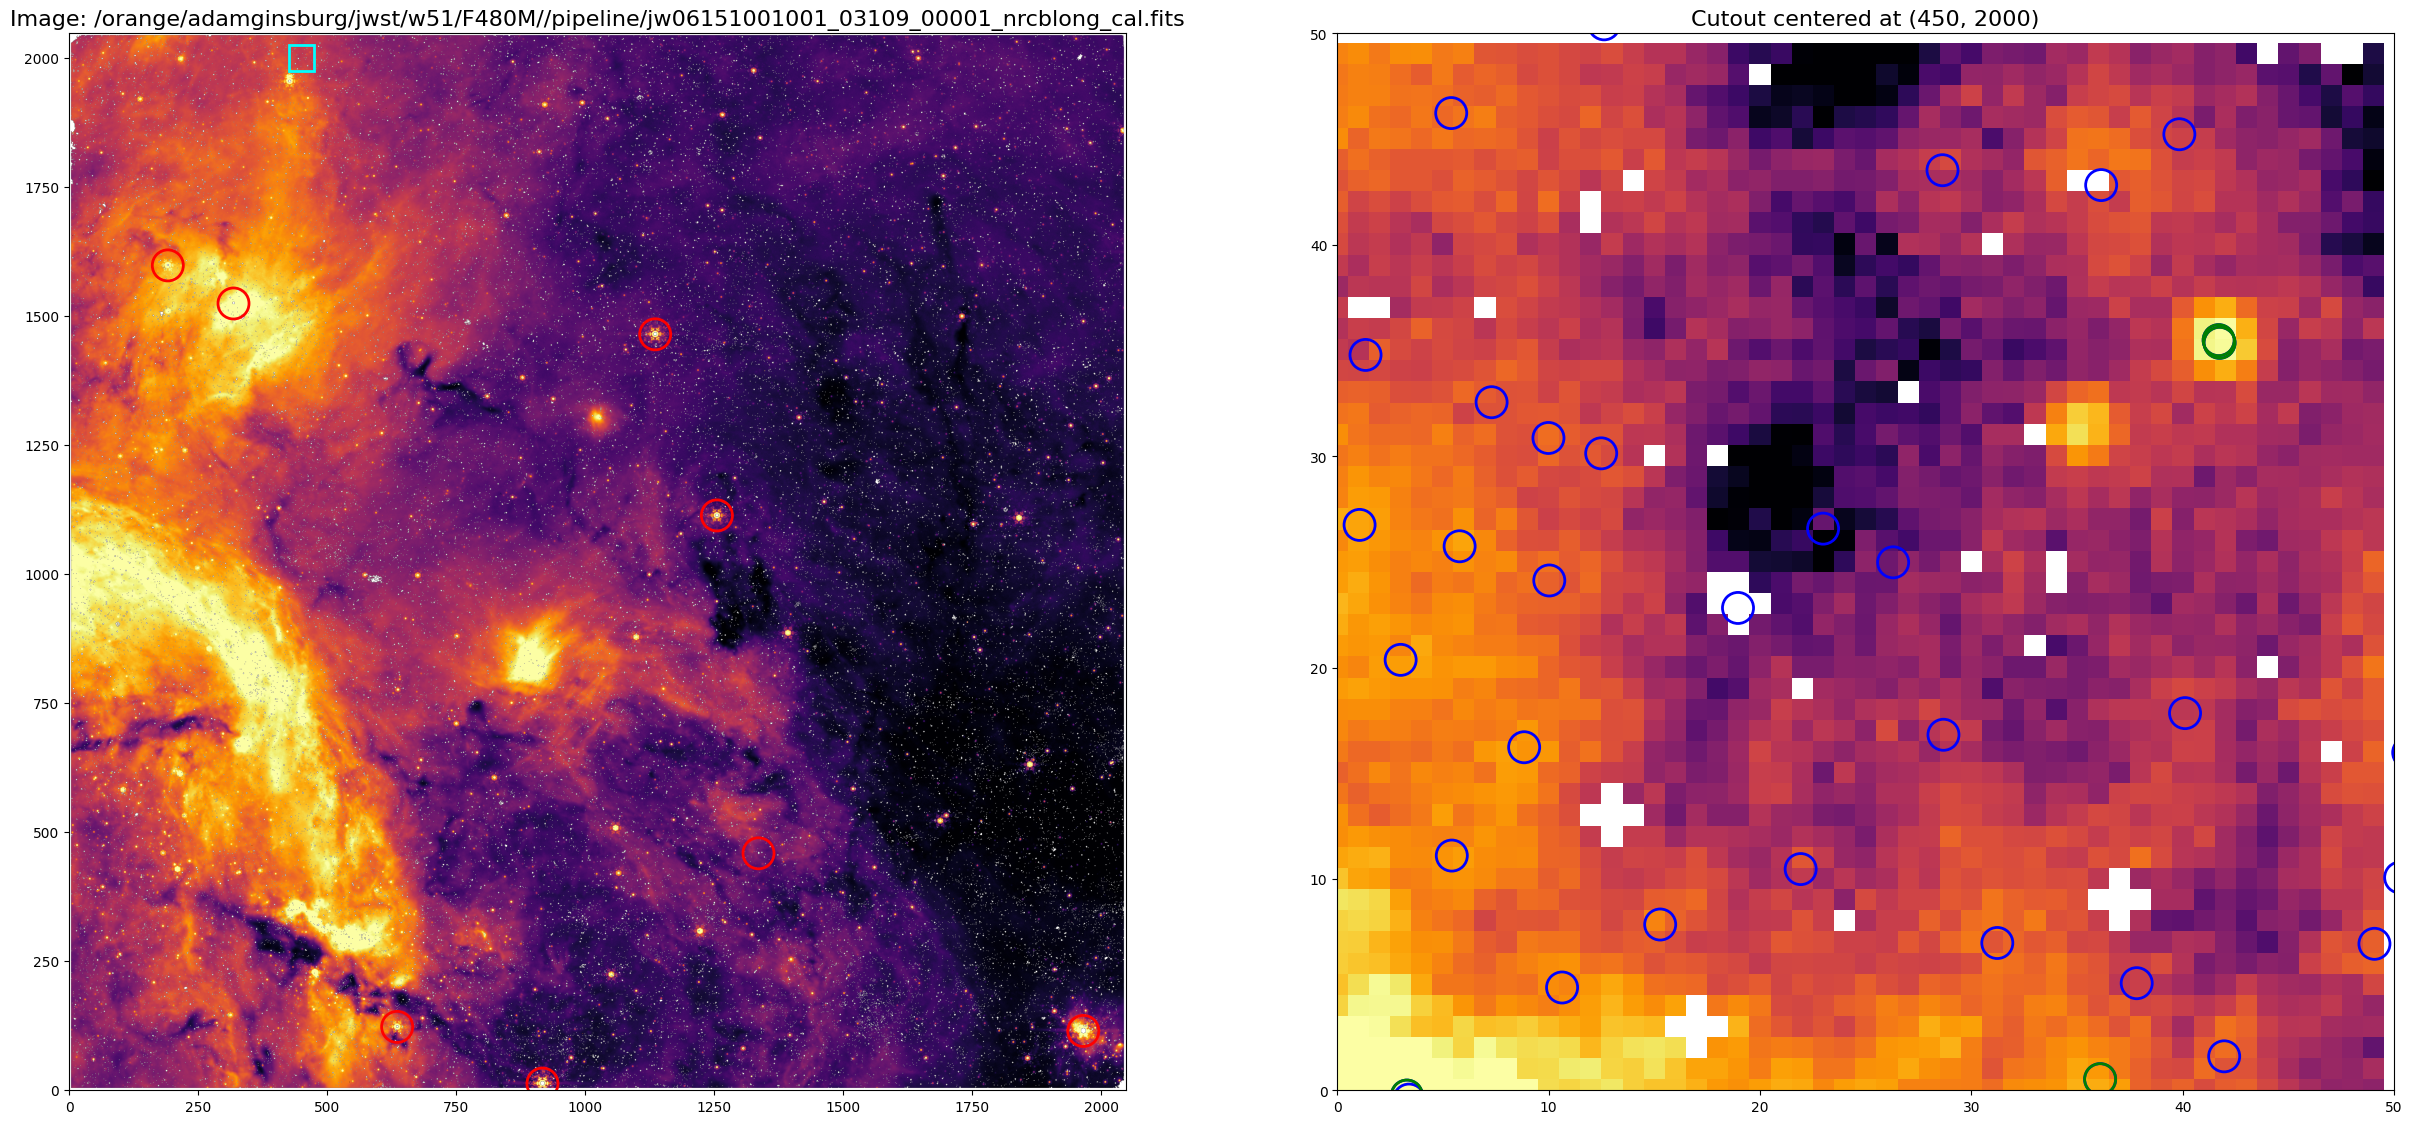

In [6]:
import glob
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import numpy as np
from jwst.datamodels import dqflags
from scipy.ndimage import label, find_objects, center_of_mass, sum_labels


def main(xpos, ypos, size=100, filter='f480m', module='nrcblong', vgroup='3109', expnum='00001' ):
    #jw06151001001_03109_00007_nrcblong_cal.fits
    imgdir = f'/orange/adamginsburg/jwst/w51/{filter.upper()}/'
    img_filename = imgdir + '/pipeline/'+f'jw06151001001_0{vgroup}_{expnum}_{module}_cal.fits'
    img = fits.open(img_filename)

    fig = plt.figure(figsize=(30,15))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    wcs_img = WCS(img[1].header)
    norm = simple_norm(img[1].data, 'asinh', min_percent=1, max_percent=99)
    ax1.imshow(img[1].data, norm=norm, origin='lower', cmap='inferno')
    square = plt.Rectangle((xpos - size/2, ypos - size/2), size, size, edgecolor='cyan', facecolor='none', lw=2)
    ax1.add_patch(square)
    ax1.set_title(f'Image: {img_filename}', fontsize=16)
    # f480m_nrcb_visit001_vgroup3109_exp00007_daophot_basic.fits
    wav = int(filter.lower()[1:4])
    if wav > 300:
        module2 = module[:-4]  #nrca or nrcb
    else:
        module2 = module
    cat_basic_filename = imgdir + f'{filter.lower()}_{module2}_visit001_vgroup{vgroup}_exp{expnum}_daophot_basic.fits'
    cat_refined_filename = imgdir + f'{filter.lower()}_{module2}_visit001_vgroup{vgroup}_exp{expnum}_daophot_refined.fits'

    #jw06151001001_03109_00007_nrcblong_align_o001_crf_satstar_catalog_newnewnewnew.fits
    sat_cat_filename = imgdir + '/pipeline/' f'jw06151001001_0{vgroup}_{expnum}_{module}_align_o001_crf_satstar_catalog_newnewnewnew.fits'

    cutout_xmin = int(xpos - size/2)
    cutout_xmax = int(xpos + size/2)
    cutout_ymin = int(ypos - size/2)
    cutout_ymax = int(ypos + size/2)
    cutout = img[1].data[cutout_ymin:cutout_ymax, cutout_xmin:cutout_xmax]
    norm = simple_norm(cutout, 'asinh', min_percent=1, max_percent=99)

    ax2.imshow(cutout, norm=norm, origin='lower', cmap='inferno')
    ax2.set_title(f'Cutout centered at ({xpos}, {ypos})', fontsize=16)
    
    cat_basic = Table.read(cat_basic_filename)
    cat_refined = Table.read(cat_refined_filename)
    sat_cat = Table.read(sat_cat_filename)

    xpos_basic = cat_basic['x_fit']
    ypos_basic = cat_basic['y_fit']
    xpos_refined = cat_refined['x_fit']
    ypos_refined = cat_refined['y_fit']
    print(sat_cat.colnames)

    xpos_sat = sat_cat['xcentroid']
    ypos_sat = sat_cat['ycentroid']
    ax1.scatter(xpos_sat, ypos_sat, s=500, edgecolor='red', facecolor='none', label='Saturated Stars Catalog', lw=2)

    ax2.scatter(xpos_basic-cutout_xmin, ypos_basic-cutout_ymin, s=500, edgecolor='blue', facecolor='none', label='Basic Catalog', lw=2)
    ax2.scatter(xpos_refined-cutout_xmin, ypos_refined-cutout_ymin, s=500, edgecolor='green', facecolor='none', label='Refined Catalog', lw=2)
    ax2.scatter(xpos_sat-cutout_xmin, ypos_sat-cutout_ymin, s=500, edgecolor='red', facecolor='none', label='Saturated Stars Catalog', lw=2)
    ax2.set_xlim(0, size)
    ax2.set_ylim(0, size)

    dqarr = fits.open(img_filename)['DQ'].data
    is_saturated = (dqarr & dqflags.pixel['SATURATED']) != 0
    labeled_array, num_features = label(is_saturated)
    centers = center_of_mass(is_saturated, labeled_array, range(1, num_features + 1))
    for center in centers:
        ycen, xcen = center
        if cutout_xmin <= xcen < cutout_xmax and cutout_ymin <= ycen < cutout_ymax:
            ax2.scatter(xcen - cutout_xmin, ycen - cutout_ymin, s=800, edgecolor='magenta', facecolor='none', label='Saturated Star Center', lw=2)
    return img['SCI'].data, img['ERR'].data, cutout
data, err, cutout = main(450, 2000, size=50, filter='f480m', module='nrcblong', vgroup='3109', expnum='00001' )   




In [7]:
from photutils.detection import DAOStarFinder
from astropy import stats
basepath = '/orange/adamginsburg/jwst/w51/'
filtered_errest = np.nanmedian(err)

fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')

filtername = 'F480M'

row = fwhm_tbl[fwhm_tbl['Filter'] == filtername]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])
print(filtered_errest)

daofind_tuned = DAOStarFinder(threshold=4 * filtered_errest,
                                  fwhm=fwhm_pix,# roundhi=1.0, roundlo=-1.0,
                                  #sharplo=0.30, sharphi=1.40)
                                  )


finstars = daofind_tuned(np.nan_to_num(cutout))
finstars.pprint(max_lines=-1)


0.24968632
 id     xcentroid          ycentroid      ...    mag          daofind_mag     
--- ------------------ ------------------ ... ---------- ---------------------
  1 3.2872962473508567 0.6449556919825515 ... -7.8496437    -5.271192192699919
  2  47.62011800886506 1.3660277161898182 ...  -6.768866    -3.298965773160279
  3 10.640078338187784  4.870714750380348 ... -7.3753123   -0.5214357356058107
  4 15.283699401065164  7.842459039259322 ... -7.3284173   -0.8235792152443688
  5  31.17410327879531  6.791675490385051 ...  -7.337681  -0.14202114387910386
  6  5.422901616912681 11.104429085736763 ... -7.3852854   -0.5461816137873649
  7   21.9311131096891 10.468241428963525 ... -7.2694826   -0.6753561798095747
  8   8.35717311462391  15.73595127028617 ... -7.3878174   -0.5805672275069581
  9 11.019405567758279 17.419751586465946 ... -7.3572297  -0.31158152847666803
 10 40.077094149552714  18.48111394718541 ... -7.2753134 -0.003460389008381245
 11 3.3018411531996916   20.2357557013819

In [16]:
cutout[28:38, 30:40]

array([[30.964502, 32.07793 , 31.690294, 31.534588, 32.212914, 32.7543  ,
        32.173683, 32.727886, 31.668354, 32.239162],
       [31.059711, 31.558249, 31.093742, 31.249773, 32.93707 , 33.14296 ,
        32.81087 , 32.932922, 33.31726 , 32.379574],
       [30.949366, 31.79206 , 31.476746, 31.357334, 33.689957, 37.110947,
        35.78524 , 33.398914, 33.09975 , 32.7724  ],
       [30.621435, 32.21477 , 32.205322,       nan, 37.998882, 41.522045,
        38.642937, 34.92624 , 32.942623, 33.111748],
       [31.585247, 30.827196, 30.6575  , 32.793053, 36.152946, 40.279076,
        38.89247 , 34.438087, 33.09562 , 33.576077],
       [31.371939, 31.61736 , 31.643291, 31.895227, 33.49506 , 34.847324,
        35.33985 , 32.82683 , 32.943775, 32.654346],
       [30.238377, 31.43596 , 30.916313, 31.385044, 31.088085, 31.70609 ,
        31.539515, 32.015682, 32.974174, 33.61422 ],
       [31.178288, 30.914255, 30.29068 , 30.532543, 30.808067, 31.755266,
        31.501379, 31.65471 , 32.3562

In [ ]:
from astropy.convolution import convolve, Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=1)
smoothed = convolve(cutout, kernel)
mask = np.isnan(cutout)
cutout[mask] = smoothed[mask]
cutout[28:38, 30:40]


array([[30.964502, 32.07793 , 31.690294, 31.534588, 32.212914, 32.7543  ,
        32.173683, 32.727886, 31.668354, 32.239162],
       [31.059711, 31.558249, 31.093742, 31.249773, 32.93707 , 33.14296 ,
        32.81087 , 32.932922, 33.31726 , 32.379574],
       [30.949366, 31.79206 , 31.476746, 31.357334, 33.689957, 37.110947,
        35.78524 , 33.398914, 33.09975 , 32.7724  ],
       [30.621435, 32.21477 , 32.205322, 33.468307, 37.998882, 41.522045,
        38.642937, 34.92624 , 32.942623, 33.111748],
       [31.585247, 30.827196, 30.6575  , 32.793053, 36.152946, 40.279076,
        38.89247 , 34.438087, 33.09562 , 33.576077],
       [31.371939, 31.61736 , 31.643291, 31.895227, 33.49506 , 34.847324,
        35.33985 , 32.82683 , 32.943775, 32.654346],
       [30.238377, 31.43596 , 30.916313, 31.385044, 31.088085, 31.70609 ,
        31.539515, 32.015682, 32.974174, 33.61422 ],
       [31.178288, 30.914255, 30.29068 , 30.532543, 30.808067, 31.755266,
        31.501379, 31.65471 , 32.3562

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64
1,1.3792772720277382,1.3289116229918991,0.2164352043502883,-0.19742943,-0.01681611538440658,25,30.713251,495.2381,-6.737035,-3.2491076683716917
2,6.7536631165532945,1.3530471475360544,0.18988509088291014,-0.87673086,-1.8110971784266725,25,32.03452,639.7965,-7.015105,-2.665466283773046
3,10.420713859252244,1.386685870975139,0.22390081784647403,-0.91769654,-1.901952645494137,25,31.866173,636.44824,-7.009408,-2.5764187488932255
4,14.311717170285512,1.381584824006165,0.2640814821797655,-0.91193783,-1.8318594535227193,25,32.564777,638.1045,-7.0122294,-2.6244782259769757
5,16.857569928163347,1.3813821088900589,0.25120154325704985,-0.84596455,-1.8223879338968108,25,32.552486,639.119,-7.0139546,-2.627116237793791
6,22.670830772741493,1.331679620987284,0.23171095948991594,0.17838089,0.01870610890779076,25,33.222374,523.5587,-6.7974133,-3.35424694269016
7,22.63564312942178,3.991798347636448,0.229648584093191,1.0201036,1.9638307481575055,25,32.47631,644.5134,-7.02308,-2.5867539978718175
8,1.3900803820516912,5.210997350986852,0.2647500195095672,0.84806305,1.9118821270128248,25,31.1692,611.4956,-6.9659834,-2.5520300581271
9,10.228702384362602,6.371498642092447,0.5678513518796976,0.1273101,0.06555152002600219,25,41.522045,871.9343,-7.3512096,-2.26345661680451


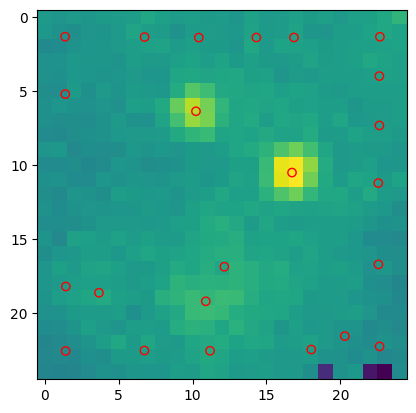

In [ ]:
plt.imshow(cutout[25:50, 25:50])
daofind_tuned = DAOStarFinder(threshold=4 * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=5.0, roundlo=-5.0,
                                  sharplo=0.10, sharphi=1.90)

fin = daofind_tuned.find_stars(cutout[25:50, 25:50], mask=mask)
plt.scatter(fin['xcentroid'], fin['ycentroid'], edgecolor='red', facecolor='none')
fin